In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

In [2]:
data = np.load('data_56x56.npz')
images_ = data['images']
lables_ = data['labels'] 
data.close() 

4


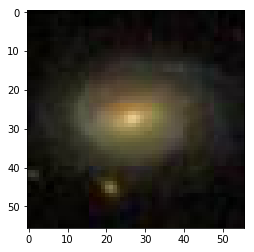

In [3]:
i = 53
print lables_[i]
plt.imshow(images_[i])

(array([3756., 3216., 3960.,    0., 3764., 6208.,    0., 6508., 6384.,
        9228.]),
 array([ 4. ,  4.7,  5.4,  6.1,  6.8,  7.5,  8.2,  8.9,  9.6, 10.3, 11. ]),
 <a list of 10 Patch objects>)

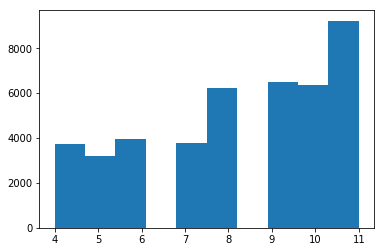

In [4]:
plt.hist(lables_[lables_>3])

(60468, 56, 56, 3)
(43024, 56, 56, 3)
7


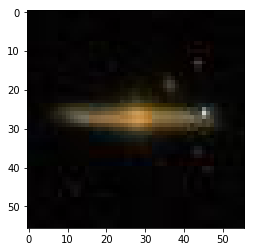

In [5]:
print images_.shape
ix, = np.where(lables_>3)

images_c = images_[ix]
lables_c = lables_[ix]-4

print images_c.shape

i = 53
plt.imshow(images_c[i])
print lables_c[i]

In [6]:
print set(lables_c)
print images_c.shape , lables_c.shape

set([0, 1, 2, 3, 4, 5, 6, 7])
(43024, 56, 56, 3) (43024,)


In [7]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [8]:
n = len(lables_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=0)

images_cc = images_c[indices]
lables_cc = lables_c[indices]

indices = np.arange(1000)
images_test  = images_cc[indices]
lables_test  = lables_cc[indices]

indices = np.arange(1000, n)
images_train = images_cc[indices]
lables_train = lables_cc[indices]

In [9]:
print images_train.shape , lables_train.shape
print images_test.shape , lables_test.shape

(42024, 56, 56, 3) (42024,)
(1000, 56, 56, 3) (1000,)


(array([ 84.,  74.,  79.,   0., 102., 120.,   0., 158., 161., 222.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 1 Patch objects>)

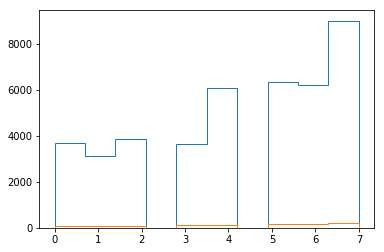

In [10]:
plt.hist(lables_train, histtype='step', label='train')
plt.hist(lables_test, histtype='step', label='test')

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(56, 56, 3), n_classes= 8):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [12]:
vgg_model = vgg6()
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs=30
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train, lables_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(images_test, lables_test),
                                  shuffle=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 54, 54, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 52, 52, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)       

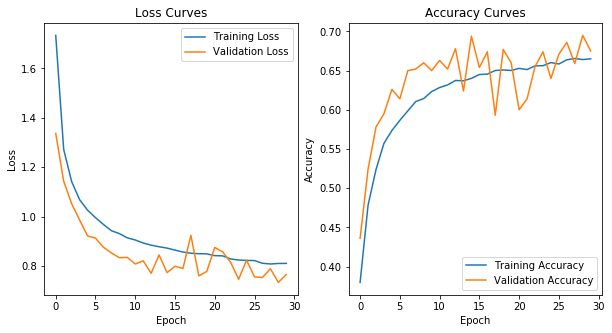

In [16]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# print vgg_model.history.history['loss']

plot_model_history(vgg_model.history)
  

In [17]:
classes = vgg_model.predict(images_test)


In [15]:
i = 999

print classes[i], lables_test[i], np.argmax(classes[i])

[2.5244751e-20 3.3670764e-16 2.2033633e-14 1.2054305e-08 6.4432865e-04
 2.3101930e-01 6.8425131e-01 8.4085040e-02] 5 6


In [19]:
vgg_model.save("CNN_inc_VGG6_test.h5")
print("Saved model to disk")

Saved model to disk
